In [1]:
import numpy as np
import uproot
import aiohttp
from matplotlib import pyplot as plt
import awkward as ak
from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

#####
#Delta R matched

In [97]:
####
# Not necessary, just a device check. Remove if desired
###
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.config.list_physical_devices('GPU'))

['/device:CPU:0']
[]


In [98]:
####
# Not necessary, just a device check. Remove if desired
###
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


In [171]:
#############
##### Deep Clean
###

#coffea init
cofevents = NanoEventsFactory.from_root('QCD_pt.root', schemaclass=NanoAODSchema).events()
####

# Filter 0s 
cevents = cofevents[ak.num(cofevents.FatJet)>0]
cevents = cevents[ak.num(cevents.GenJetAK8)>0]
fj = cevents.FatJet
gj = cevents.GenJetAK8


#this should give fatjets closest to genjets, and since genjets are already stripped of zeroes, this should just line up (pfft just kidding)
deltarray = cevents.GenJetAK8.nearest(cevents.FatJet)[:,0]
deltaR = cevents.GenJetAK8[:,0].delta_r(cevents.GenJetAK8.nearest(cevents.FatJet)[:,0])
deltar = gj[:,0].delta_r(gj.nearest(fj[:]))

fatster = fj[:, 0]
qmatch = fj.matched_gen #retrieves matched genjet ID'd to fatjet, qmatch IS a PhiEtaMCollection Array and is a genjet, so we treat it as such

#proving nearest fatjet to each qmatched gen jet is just the normally ordered "fj" fatjet array
qdelt = qmatch[:,0].delta_r(qmatch.nearest(fj)[:,0])
qdelter = qmatch[:,0].delta_r(fj[:,0])
print(qdelt)
print(qdelter)
pdq = (qdelt == qdelter)
print(ak.all(pdq))

delt = gj[:,0].delta_r(gj.nearest(fj)[:,0])
delter = gj[:,0].delta_r(fj[:,0])
print(delt)
print(delter)
adq = (delt == delter)
print(ak.all(adq))

# pdq is True => qmatch is 1:1 matched with fj, adq is not
# Therefore, we will use qmatch as the default genjet instead of gj = cevents.GenJetAK8
# We can continue to use fj = cevents.FatJet as this is matched with qmatch

# Proving there are no None values and all values of the matched retain the properties of the 0 filtering done earlier
print("NUM:", ak.num(qmatch.mass))
print(ak.all(ak.num(qmatch.mass)>0))

print("No Nones PT:", ak.all(qmatch.pt[:,0] != None))
print("No Nones Mass:", ak.all(qmatch.mass[:,0] != None))
print(len(qmatch))

# Delta R filtering to keep everything below 0.4
deltafilter = qmatch[:,0].delta_r(fj[:,0]) < 0.4
eventsHigh = (qmatch[~deltafilter], fj[~deltafilter])  # Save events >= 0.4 as a tuple of arrays for consideration later
temp = qmatch[deltafilter]  # Making sure qmatch isn't overwritten before being delta filtered in fj
fj = fj[deltafilter]
qmatch = temp   # Overwriting qmatch
print(qmatch.pt)
print(len(eventsHigh[0]))
print(len(qmatch), len(fj))
# print highest delta r in retained and lowest in filtered out to make sure filtering assigned as it should
print("Max/min delta r in retained vs filtered out:", ak.max(qmatch[:,0].delta_r(fj[:,0])), ak.min(eventsHigh[0][:,0].delta_r(eventsHigh[1][:,0])))  

#Assignment using fj and qmatch for our fat (reco) and gen respectively, using leading jets
print(qmatch.pt[:,0])
jet_recopt = ak.to_numpy(fj[:,0].pt)
jet_recomass = ak.to_numpy(fj[:,0].mass)
jet_genpt = ak.to_numpy(qmatch[:,0].pt)
jet_genmass = ak.to_numpy(qmatch[:,0].mass)

#Ensuring no Nones have made it in during conversion 
print("No Nones PT:", ak.all(jet_genpt != None))
print("No Nones Mass:", ak.all(jet_genpt != None))

jetarr = [jet_recopt, jet_recomass, jet_genpt, jet_genmass]

amt = len(jet_genmass)//2


jet_recophi = fj.phi
jet_recoeta = fj.eta
jet_geneta = qmatch.eta
jet_genphi = qmatch.phi
#jet_genpt = quantvals[-2]

print(amt)
theta0_G = np.column_stack((
    jet_genmass[amt:-1],   # 1 dee
    jet_genpt[amt:-1]    # 2 dee
))

theta0_S = np.column_stack((
    jet_recomass[amt:-1],   # 1 dee
    jet_recopt[amt:-1]    # 2 dee
))


# Natural  - Unfortunately MC data becomes asymmetrical when split after all the filtering, so only up to penultimate values are in test set for symmetry
theta_unknown_G = np.column_stack([
    jet_genmass[:amt],   # 1 dee
    jet_genpt[:amt]    # 2 dee
])

theta_unknown_S = np.column_stack([
    jet_recomass[:amt],   # 1 dee
    jet_recopt[:amt]    # 2 dee
])

theta0 = np.stack((theta0_G, theta0_S), axis=1)

print("CLEAR")

[0.0152, 0.0138, 0.00787, 0.028, 0.0116, ... 0.00176, 0.0116, 0.00769, 0.0143]
[0.0152, 0.0138, 0.00787, 0.028, 0.0116, ... 0.00176, 0.0116, 0.00769, 0.0143]
True
[0.0152, 1.99, 0.00787, 0.00693, 0.0116, ... 0.00176, 0.0116, 0.00769, 0.0143]
[0.0152, 1.99, 0.00787, 3.35, 0.0116, ... 3.14, 0.00176, 0.0116, 0.00769, 0.0143]
False
NUM: [2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, ... 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2]
True
No Nones PT: True
No Nones Mass: True
300792
[[379, 331], [175], [1.37e+03, ... [5.96e+03, 5.95e+03], [2.91e+03, 2.81e+03]]
25
300779 300779
Max/min delta r in retained vs filtered out: 0.39850938 0.4002885
[379, 175, 1.37e+03, 697, 921, 345, ... 4.36e+03, 662, 2.3e+03, 5.96e+03, 2.91e+03]
No Nones PT: True
No Nones Mass: True
150389
CLEAR


In [100]:
print("Shape theta0_G:", theta0_G.shape)
print("Shape 0_S:", theta0_S.shape)
print("Shape theta0:", theta0.shape)
print("Shape unknown s:", theta_unknown_S.shape)

Shape theta0_G: (150389, 2)
Shape 0_S: (150389, 2)
Shape theta0: (150389, 2, 2)
Shape unknown s: (150389, 2)


In [95]:
print(len(jet_genmass)/2)
amt = len(jet_genmass)//2
print(amt)

150389.5
150389


In [79]:
print(theta0_G)
print(theta_unknown_G)
print(theta0)

[[  61.21875  378.66748]
 [  61.625    174.81387]
 [  46.5     1373.5568 ]
 ...
 [ 229.125   1476.186  ]
 [  59.15625  816.8699 ]
 [ 273.25    2554.3953 ]]
[[ 154.375   2080.6157 ]
 [ 138.125    702.45856]
 [  53.71875  886.5602 ]
 ...
 [  52.25     661.56055]
 [ 148.625   2303.6921 ]
 [ 397.5     5961.3716 ]]
[[[  61.21875  378.66748]
  [  59.59375  392.     ]]

 [[  61.625    174.81387]
  [  68.6875   188.75   ]]

 [[  46.5     1373.5568 ]
  [  70.75    1454.     ]]

 ...

 [[ 229.125   1476.186  ]
  [ 227.625   1467.     ]]

 [[  59.15625  816.8699 ]
  [ 103.8125   921.     ]]

 [[ 273.25    2554.3953 ]
  [ 271.      2630.     ]]]


(array([6.0000e+00, 1.9000e+01, 5.8060e+03, 1.2075e+04, 9.1490e+03,
        7.2410e+03, 6.1340e+03, 5.2070e+03, 4.7130e+03, 4.1330e+03,
        3.8170e+03, 3.4880e+03, 3.1930e+03, 3.1350e+03, 2.8120e+03,
        2.6230e+03, 2.4150e+03, 2.4290e+03, 2.2520e+03, 2.1460e+03,
        2.0800e+03, 2.0170e+03, 1.9350e+03, 1.8910e+03, 1.8390e+03,
        1.7030e+03, 1.7140e+03, 1.6060e+03, 1.5720e+03, 1.5380e+03,
        1.4500e+03, 1.4870e+03, 1.4070e+03, 1.3870e+03, 1.3400e+03,
        1.3320e+03, 1.2740e+03, 1.3250e+03, 1.2230e+03, 1.2090e+03,
        1.2030e+03, 1.2110e+03, 1.1290e+03, 1.0990e+03, 1.1220e+03,
        1.0350e+03, 9.9500e+02, 9.6500e+02, 9.2600e+02, 9.5000e+02,
        8.6300e+02, 8.8200e+02, 8.8200e+02, 7.9500e+02, 8.2000e+02,
        7.6700e+02, 8.0900e+02, 7.1200e+02, 6.9600e+02, 6.9200e+02,
        6.3900e+02, 6.1700e+02, 6.3300e+02, 5.9900e+02, 6.3800e+02,
        5.6400e+02, 5.8600e+02, 5.4600e+02, 5.4900e+02, 5.3900e+02,
        5.2400e+02, 5.1600e+02, 4.6000e+02, 4.54

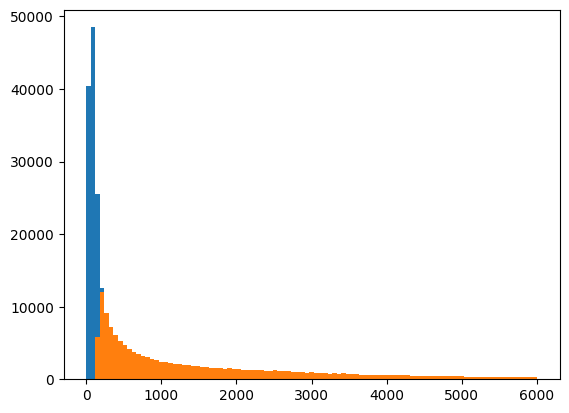

In [81]:
plt.hist( theta0_G[:,0], bins=np.linspace(0,6000, 100) )
plt.hist( theta0_G[:,1], bins=np.linspace(0,6000, 100) )

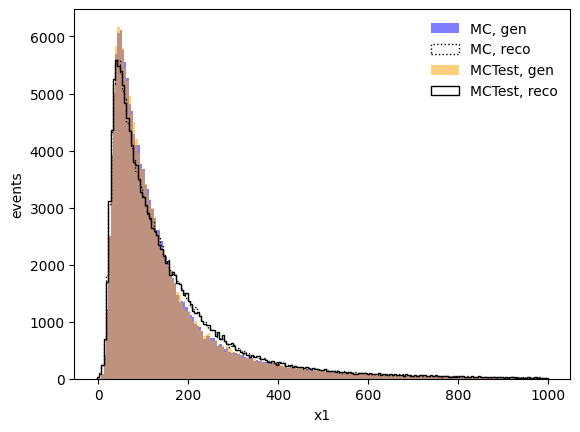

In [82]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta0_S[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="MCTest, reco")
plt.xlabel("x1")
plt.ylabel("events")
plt.legend(frameon=False)


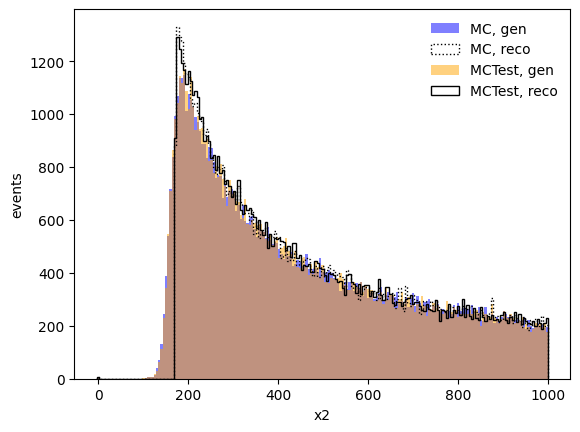

In [83]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta0_S[:,1],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:, 1],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta_unknown_S[:, 1],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="MCTest, reco")
plt.xlabel("x2")
plt.ylabel("events")
plt.legend(frameon=False)


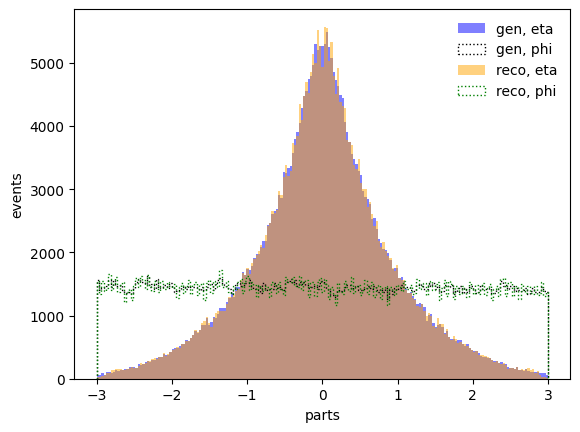

In [84]:
_,_,_=plt.hist(jet_geneta[:,0],bins=np.linspace(-3,3,200),color='blue',alpha=0.5,label="gen, eta")
_,_,_=plt.hist(jet_genphi[:,0],bins=np.linspace(-3,3,200),histtype="step",color='black',ls=':',label="gen, phi")
_,_,_=plt.hist(jet_recoeta[:,0],bins=np.linspace(-3,3,200),color='orange',alpha=0.5,label="reco, eta")
_,_,_=plt.hist(jet_recophi[:,0],bins=np.linspace(-3,3,200),histtype="step",color='green',ls=':',label="reco, phi")
#_,_,_=plt.hist(jet_genmass[:],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
#_,_,_=plt.hist(jet_genpt[:],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("parts")
plt.ylabel("events")
plt.legend(frameon=False)

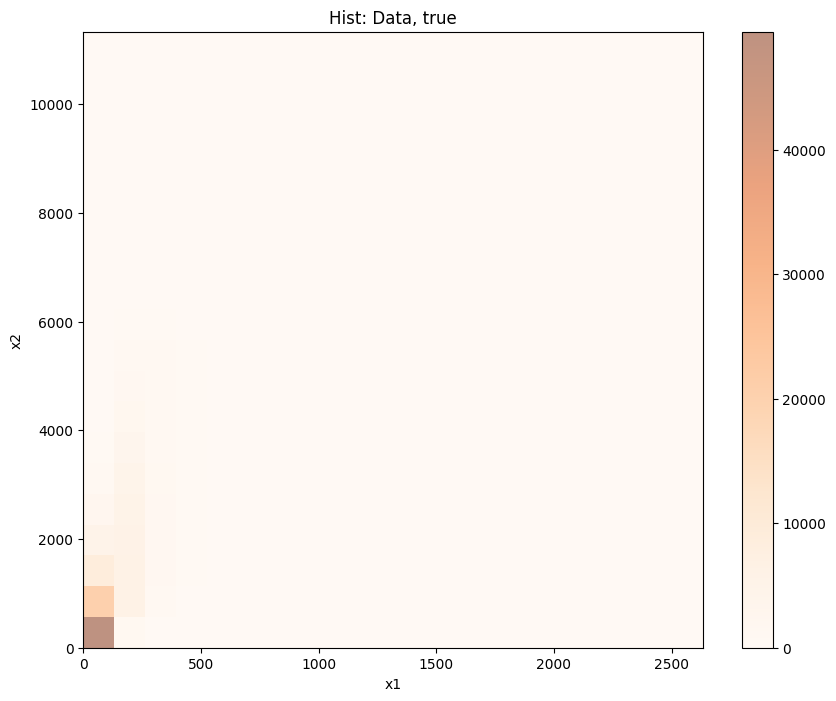

In [85]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(theta_unknown_S[:, 0], theta_unknown_S[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Hist: Data, true")
plt.show()

In [88]:
#Defining the cnn model with 3 full connected layers, 2D input, 50 nodes per. Sigmoid output, as its binary classification
inputs = Input((2,))  # 2D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [89]:
myweights = of.omnifold(theta0,theta_unknown_S,20,model)

theta0G (150389, 2), labels (150389,), labels unknown (150389,), theta 0(150389, 2, 2), theta unknown s(150389, 2)
16/16 [==============================] - 0s 4ms/step


In [180]:
print("Shape theta0_G:", theta0_G.shape)
print("Shape weights:", myweights.shape)


Shape theta0_G: (150389, 2)
Shape weights: (20, 2, 150389)


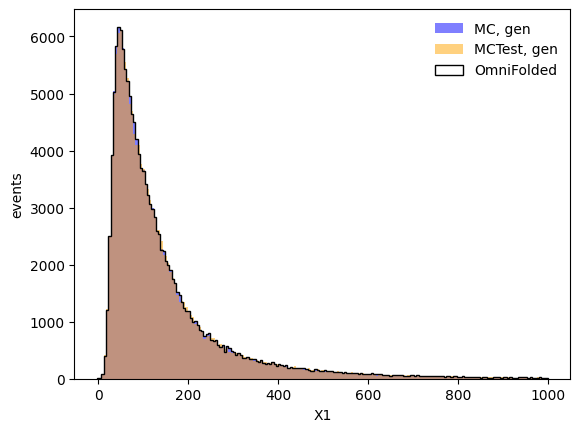

In [172]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
#_,_,_=plt.hist(theta_unknown_S[:,0],bins=np.linspace(-3,1000,200),color=['green'],alpha=0.5, histtype="step",label="got")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

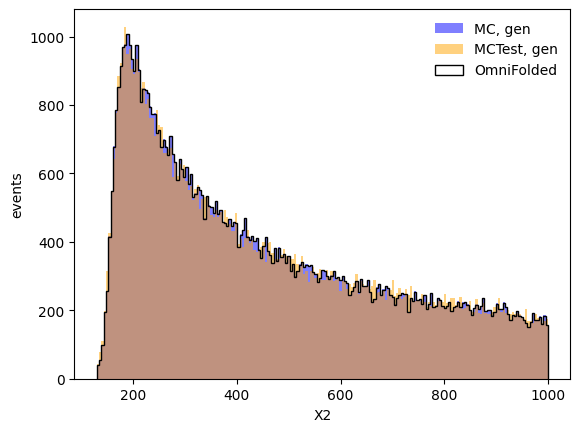

In [179]:
 _,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(130,1000,200),color=['blue'],alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta_unknown_G[:,1],bins=np.linspace(130,1000,200),color=['orange'],alpha=0.5,label="MCTest, gen")
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(130,1000,200),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
#_,_,_=plt.hist(theta_unknown_S[:,1],bins=np.linspace(170,171,20),color=['green'],alpha=0.5, histtype="step",label="got")
plt.xlabel("X2")
plt.ylabel("events")
plt.legend(frameon=False)

In [131]:
print(myweights[1, 0,:])
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,0],theta_unknown_G[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()

[1.02634859 1.00566864 1.06749487 ... 1.065256   1.19099784 1.41157591]


In [22]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,1],theta_unknown_G[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()